In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-05-07 09:59:09.978741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class NTxentLoss():
    def __init__(self,
                 n_org=int(),
                 n_rep=int(), 
                 tau=0.05,
                 **kwargs
                 ):
        """ Init. """
        self.n_org = n_org
        self.n_rep = n_rep
        self.tau = tau
        
        """ Generate temporal labels and diag masks. """
        self.labels = tf.one_hot(tf.range(n_org), n_org * 2 - 1)
        self.mask_not_diag = tf.constant(tf.cast(1 - tf.eye(n_org), tf.bool))


    #def call(self, y_true, y_pred):
        # Calculando a perda usando a função NTxentLoss
        #loss, _, _ = self.ntxent_loss.compute_loss(y_true, y_pred)
        #return loss
        
    
    @tf.function 
    def drop_diag(self, x):
        x = tf.boolean_mask(x, self.mask_not_diag)
        return tf.reshape(x, (self.n_org, self.n_org-1))
    
    
    @tf.function 
    def compute_loss(self, emb_org, emb_rep):
        """ NTxent Loss function for neural audio fingerprint.
        
        • Every input embeddings must be L2-normalized... 
        • Batch-size must be an even number.
        
        Args
        ----
        emb_org: tensor of shape (nO, d)
            nO is the number of original samples. d is dimension of embeddings. 
        emb_rep: tensor of shape (nR, d)        
            nR is the number of replica (=augmented) samples.
            
        Returns
        -------
	    (loss, sim_mtx, labels)
        
        """
        #print(f"{}")
        ha, hb = emb_org, emb_rep # assert(len(emb_org)==len(emb_rep))
        #print(f"{}")
        logits_aa = tf.matmul(ha, ha, transpose_b=True) / self.tau
        logits_aa = self.drop_diag(logits_aa) # modified
        logits_bb = tf.matmul(hb, hb, transpose_b=True) / self.tau
        logits_bb = self.drop_diag(logits_bb) # modified
        logits_ab = tf.matmul(ha, hb, transpose_b=True) / self.tau
        logits_ba = tf.matmul(hb, ha, transpose_b=True) / self.tau
        loss_a = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ab, logits_aa], 1))
        loss_b = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ba, logits_bb], 1))
        return loss_a + loss_b, tf.concat([logits_ab, logits_aa], 1), self.labels

In [21]:
# Criando a base de dados
num_samples = 1080
X = np.random.uniform(-1, 1, (num_samples, 2))
y = np.random.randint(0, 3, num_samples)
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [22]:
# Treinamento
epochs = 10
batch_size = 120
num_batches = num_samples // batch_size

In [23]:
for batch in range(num_batches):
    start = batch * batch_size
    end = start + batch_size
    print(batch)
    print(start)
    print(end)
    print("fim")

0
0
120
fim
1
120
240
fim
2
240
360
fim
3
360
480
fim
4
480
600
fim
5
600
720
fim
6
720
840
fim
7
840
960
fim
8
960
1080
fim


In [28]:
# Definindo o modelo usando Subclassing API
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation='sigmoid', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(4, activation='sigmoid', bias_initializer='zeros')
        self.dense3 = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)


# Definindo o modelo
model = MyModel()

# Definindo o otimizador
total_nsteps = epochs * len(X)
lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=float(1e-4),
            decay_steps=total_nsteps,
            alpha=1e-06)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Definindo a função de perda
loss_object = NTxentLoss(
            n_org=60,
            n_rep=60,
            tau=0.05)

# Métricas para monitorar o treinamento
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [29]:
#predictions = [] 
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        print("Shape of labels:", labels.shape)
        print("Shape of predictions:", predictions.shape)
        loss,_,_ = loss_object.compute_loss(labels[:60,:], predictions[60:,:])#loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)



for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(X[start:end], y[start:end])

    if num_samples % batch_size != 0:
        start = num_batches * batch_size
        train_step(X[start:], y[start:])

    model.save_weights(f'checkpoint_epoch_{epoch + 1}.h5')
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')

Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Epoch 1, Loss: 24.38204574584961, Accuracy: 0.31388887763023376
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3

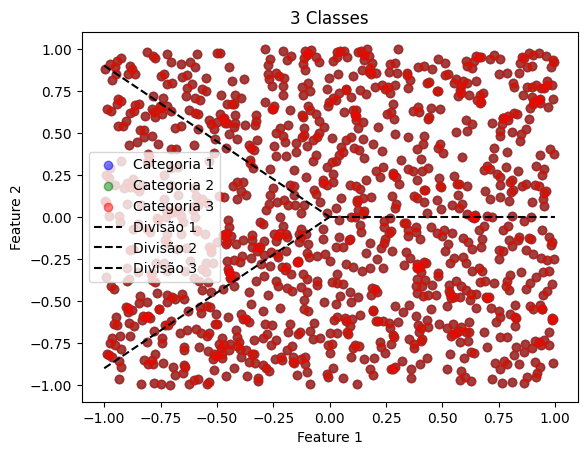

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x_div1 = np.linspace(-1, 0, 100)
y_div1 = -0.9 * x_div1

x_div2 = np.linspace(-1, 0, 100)
y_div2 = 0.9 * x_div2

x_div3 = np.array([0, 1])  
y_div3 = np.array([0, 0])  

plt.scatter(X[:, 0], X[:, 1], c='blue', label='Categoria 1', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='green', label='Categoria 2', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='red', label='Categoria 3', alpha=0.5)

plt.plot(x_div1, y_div1, c='black', linestyle='--', label='Divisão 1')
plt.plot(x_div2, y_div2, c='black', linestyle='--', label='Divisão 2')
plt.plot(x_div3, y_div3, c='black', linestyle='--', label='Divisão 3')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('3 Classes')
plt.legend()
plt.show()

0
0
120
fim
1
120
240
fim
2
240
360
fim
3
360
480
fim
4
480
600
fim
5
600
720
fim
6
720
840
fim
7
840
960
fim
8
960
1080
fim
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Epoch 1, Loss: 25.09087562561035, Accuracy: 0.34351852536201477
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labels: (120, 3)
Shape of predictions: (120, 3)
Shape of labe

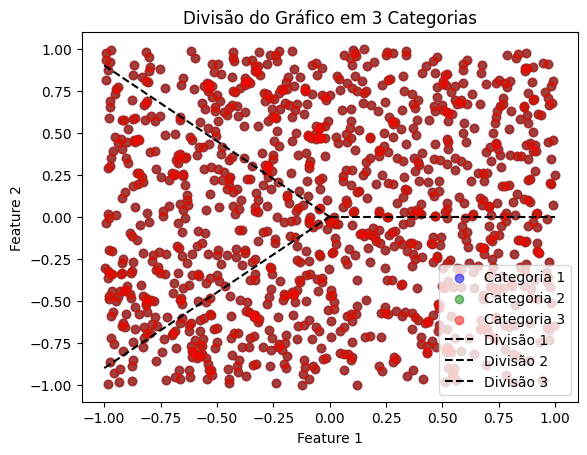

In [31]:
class NTxentLoss():
    def __init__(self,
                 n_org=int(),
                 n_rep=int(), 
                 tau=0.05,
                 **kwargs
                 ):
        """ Init. """
        self.n_org = n_org
        self.n_rep = n_rep
        self.tau = tau
        
        """ Generate temporal labels and diag masks. """
        self.labels = tf.one_hot(tf.range(n_org), n_org * 2 - 1)
        self.mask_not_diag = tf.constant(tf.cast(1 - tf.eye(n_org), tf.bool))


    #def call(self, y_true, y_pred):
        # Calculando a perda usando a função NTxentLoss
        #loss, _, _ = self.ntxent_loss.compute_loss(y_true, y_pred)
        #return loss
        
    
    @tf.function 
    def drop_diag(self, x):
        x = tf.boolean_mask(x, self.mask_not_diag)
        return tf.reshape(x, (self.n_org, self.n_org-1))
    
    
    @tf.function 
    def compute_loss(self, emb_org, emb_rep):
        """ NTxent Loss function for neural audio fingerprint.
        
        • Every input embeddings must be L2-normalized... 
        • Batch-size must be an even number.
        
        Args
        ----
        emb_org: tensor of shape (nO, d)
            nO is the number of original samples. d is dimension of embeddings. 
        emb_rep: tensor of shape (nR, d)        
            nR is the number of replica (=augmented) samples.
            
        Returns
        -------
	    (loss, sim_mtx, labels)
        
        """
        #print(f"{}")
        ha, hb = emb_org, emb_rep # assert(len(emb_org)==len(emb_rep))
        #print(f"{}")
        logits_aa = tf.matmul(ha, ha, transpose_b=True) / self.tau
        logits_aa = self.drop_diag(logits_aa) # modified
        logits_bb = tf.matmul(hb, hb, transpose_b=True) / self.tau
        logits_bb = self.drop_diag(logits_bb) # modified
        logits_ab = tf.matmul(ha, hb, transpose_b=True) / self.tau
        logits_ba = tf.matmul(hb, ha, transpose_b=True) / self.tau
        loss_a = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ab, logits_aa], 1))
        loss_b = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ba, logits_bb], 1))
        return loss_a + loss_b, tf.concat([logits_ab, logits_aa], 1), self.labels
    




# Criando a base de dados
num_samples = 1080
X = np.random.uniform(-1, 1, (num_samples, 2))
y = np.random.randint(0, 3, num_samples)
y = tf.keras.utils.to_categorical(y)

# Treino
epochs = 100
batch_size = 120
num_batches = num_samples // batch_size

for batch in range(num_batches):
    start = batch * batch_size
    end = start + batch_size
    print(batch)
    print(start)
    print(end)
    print("fim")


# Definindo o modelo usando Subclassing API
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation='sigmoid', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(4, activation='sigmoid', bias_initializer='zeros')
        self.dense3 = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x2 = self.dense2(x)
        return self.dense3(x2)


# Definindo o modelo
model = MyModel()

# Definindo o otimizador
total_nsteps = epochs * len(X)
lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=float(1e-4),
            decay_steps=total_nsteps,
            alpha=1e-06)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Definindo a função de perda
loss_object = NTxentLoss(
            n_org=60,
            n_rep=60,
            tau=0.05)

# Métricas para monitorar o treinamento
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

#predictions = [] 
# Função para realizar uma etapa de treinamento
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        # Verificando as dimensões de labels e predictions
        print("Shape of labels:", labels.shape)
        print("Shape of predictions:", predictions.shape)
        loss,_,_ = loss_object.compute_loss(labels[:60,:], predictions[60:,:])#loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)



for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(X[start:end], y[start:end])

    # Lidando com o último lote, que pode ter um tamanho diferente
    if num_samples % batch_size != 0:
        start = num_batches * batch_size
        train_step(X[start:], y[start:])
    
    # Salvando o checkpoint
    model.save_weights(f'checkpoint_epoch_{epoch + 1}.h5')
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')


import numpy as np
import matplotlib.pyplot as plt

# Definindo as linhas de divisão
x_div1 = np.linspace(-1, 0, 100)
y_div1 = -0.9 * x_div1

x_div2 = np.linspace(-1, 0, 100)
y_div2 = 0.9 * x_div2

# Definindo a linha vertical para a parte positiva de x
x_div3 = np.array([0, 1])  # vertical line
y_div3 = np.array([0, 0])  # from y=-1 to y=1

# Plotando os dados de entrada ('x') divididos em três categorias
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Categoria 1', alpha=0.5)  # Categoria 1
plt.scatter(X[:, 0], X[:, 1], c='green', label='Categoria 2', alpha=0.5)  # Categoria 2
plt.scatter(X[:, 0], X[:, 1], c='red', label='Categoria 3', alpha=0.5)   # Categoria 3

# Plotando as linhas de divisão
plt.plot(x_div1, y_div1, c='black', linestyle='--', label='Divisão 1')
plt.plot(x_div2, y_div2, c='black', linestyle='--', label='Divisão 2')
plt.plot(x_div3, y_div3, c='black', linestyle='--', label='Divisão 3')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Divisão do Gráfico em 3 Categorias')
plt.legend()
plt.show()

In [132]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class NTxentLoss():
    def __init__(self, n_org=int(), n_rep=int(), tau=0.05, **kwargs):
        self.n_org = n_org
        self.n_rep = n_rep
        self.tau = tau
        self.labels = tf.one_hot(tf.range(n_org), n_org * 2 - 1)
        self.mask_not_diag = tf.constant(tf.cast(1 - tf.eye(n_org), tf.bool))
    
    @tf.function 
    def drop_diag(self, x):
        x = tf.boolean_mask(x, self.mask_not_diag)
        return tf.reshape(x, (self.n_org, self.n_org-1))
    
    @tf.function 
    def compute_loss(self, emb_org, emb_rep):
        ha, hb = emb_org, emb_rep
        logits_aa = tf.matmul(ha, ha, transpose_b=True) / self.tau
        logits_aa = self.drop_diag(logits_aa)
        logits_bb = tf.matmul(hb, hb, transpose_b=True) / self.tau
        logits_bb = self.drop_diag(logits_bb)
        logits_ab = tf.matmul(ha, hb, transpose_b=True) / self.tau
        logits_ba = tf.matmul(hb, ha, transpose_b=True) / self.tau
        loss_a = tf.compat.v1.losses.softmax_cross_entropy(self.labels, tf.concat([logits_ab, logits_aa], 1))
        loss_b = tf.compat.v1.losses.softmax_cross_entropy(self.labels, tf.concat([logits_ba, logits_bb], 1))
        return loss_a + loss_b, tf.concat([logits_ab, logits_aa], 1), self.labels

In [143]:
# Criando a base de dados
num_samples = 2000
X = np.random.uniform(-1, 1, (num_samples, 2))
y = np.random.randint(0, 3, num_samples)
y = tf.keras.utils.to_categorical(y, num_classes=3)



# Definir o modelo usando Subclassing API
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4, activation='sigmoid', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(3, activation='softmax')
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Definir o otimizador
epochs = 20
batch_size = 120

optimizer = tf.keras.optimizers.Adam()

# Definindo a função de perda
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Métricas
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')


# Função para realizar uma etapa de treino
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        #loss,_,_ = loss_object.compute_loss(labels[:60,:], predictions[60:,:])
        #print(labels)
        #print(predictions)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)


# Definir o modelo
model = MyModel()

# Treino
num_batches = num_samples // batch_size
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(X[start:end], y[start:end])
    
    if num_samples % batch_size != 0:
        start = num_batches * batch_size
        train_step(X[start:], y[start:])

    model.save_weights(f'checkpoint_epoch_{epoch + 1}.h5')
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')

Epoch 1, Loss: 1.2583094835281372, Accuracy: 0.3240000009536743
Epoch 2, Loss: 1.2279558181762695, Accuracy: 0.3240000009536743
Epoch 3, Loss: 1.2019120454788208, Accuracy: 0.3240000009536743
Epoch 4, Loss: 1.1801027059555054, Accuracy: 0.3240000009536743
Epoch 5, Loss: 1.1621462106704712, Accuracy: 0.3240000009536743
Epoch 6, Loss: 1.1475608348846436, Accuracy: 0.3240000009536743
Epoch 7, Loss: 1.1358579397201538, Accuracy: 0.3240000009536743
Epoch 8, Loss: 1.126577615737915, Accuracy: 0.3240000009536743
Epoch 9, Loss: 1.1193019151687622, Accuracy: 0.3240000009536743
Epoch 10, Loss: 1.1136614084243774, Accuracy: 0.3240000009536743
Epoch 11, Loss: 1.109336495399475, Accuracy: 0.3240000009536743
Epoch 12, Loss: 1.1060566902160645, Accuracy: 0.3240000009536743
Epoch 13, Loss: 1.1035956144332886, Accuracy: 0.3240000009536743
Epoch 14, Loss: 1.1017688512802124, Accuracy: 0.3240000009536743
Epoch 15, Loss: 1.1004271507263184, Accuracy: 0.3240000009536743
Epoch 16, Loss: 1.099452018737793, A

Epoch 1, Loss: 21.374692916870117, Accuracy: 0.3490740656852722
Epoch 2, Loss: 21.362302780151367, Accuracy: 0.3490740656852722
Epoch 3, Loss: 21.35036849975586, Accuracy: 0.3490740656852722
Epoch 4, Loss: 21.33875274658203, Accuracy: 0.3490740656852722
Epoch 5, Loss: 21.327455520629883, Accuracy: 0.3490740656852722
Epoch 6, Loss: 21.31647300720215, Accuracy: 0.3490740656852722
Epoch 7, Loss: 21.30581283569336, Accuracy: 0.3490740656852722
Epoch 8, Loss: 21.29547691345215, Accuracy: 0.3490740656852722
Epoch 9, Loss: 21.28546142578125, Accuracy: 0.3490740656852722
Epoch 10, Loss: 21.275758743286133, Accuracy: 0.3490740656852722
Epoch 11, Loss: 21.266372680664062, Accuracy: 0.3490740656852722
Epoch 12, Loss: 21.257293701171875, Accuracy: 0.3490740656852722
Epoch 13, Loss: 21.248523712158203, Accuracy: 0.3490740656852722
Epoch 14, Loss: 21.24005126953125, Accuracy: 0.3490740656852722
Epoch 15, Loss: 21.23187255859375, Accuracy: 0.3490740656852722
Epoch 16, Loss: 21.223983764648438, Accura

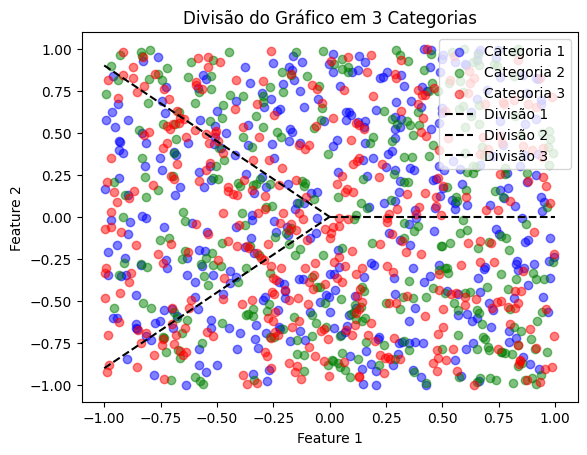

In [167]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Definindo o modelo usando Subclassing API
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(4, activation='sigmoid', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Definindo a função de perda
class NTxentLoss():
    def __init__(self,
                 n_org=int(),
                 n_rep=int(), 
                 tau=0.05,
                 **kwargs
                 ):
        """ Init. """
        self.n_org = n_org
        self.n_rep = n_rep
        self.tau = tau
        
        """ Generate temporal labels and diag masks. """
        self.labels = tf.one_hot(tf.range(n_org), n_org * 2 - 1)
        self.mask_not_diag = tf.constant(tf.cast(1 - tf.eye(n_org), tf.bool))

    @tf.function 
    def drop_diag(self, x):
        x = tf.boolean_mask(x, self.mask_not_diag)
        return tf.reshape(x, (self.n_org, self.n_org-1))
    
    @tf.function 
    def compute_loss(self, emb_org, emb_rep):
        ha, hb = emb_org, emb_rep 
        logits_aa = tf.matmul(ha, ha, transpose_b=True) / self.tau
        logits_aa = self.drop_diag(logits_aa) 
        logits_bb = tf.matmul(hb, hb, transpose_b=True) / self.tau
        logits_bb = self.drop_diag(logits_bb) 
        logits_ab = tf.matmul(ha, hb, transpose_b=True) / self.tau
        logits_ba = tf.matmul(hb, ha, transpose_b=True) / self.tau
        loss_a = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ab, logits_aa], 1))
        loss_b = tf.compat.v1.losses.softmax_cross_entropy(
            self.labels, tf.concat([logits_ba, logits_bb], 1))
        return loss_a + loss_b, tf.concat([logits_ab, logits_aa], 1), self.labels

# Criando a base de dados
num_samples = 1080
X = np.random.uniform(-1, 1, (num_samples, 2))
y = np.random.randint(0, 3, num_samples)
y = tf.keras.utils.to_categorical(y)

# Definindo o modelo
model = MyModel()

# Definindo o otimizador
epochs = 100
total_nsteps = epochs * len(X)
lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=float(1e-4),
            decay_steps=total_nsteps,
            alpha=1e-06)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Definindo a função de perda
loss_object = NTxentLoss(
            n_org=60,
            n_rep=60,
            tau=0.05)

# Métricas para monitorar o treinamento
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# Função para realizar uma etapa de treinamento
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss,_,_ = loss_object.compute_loss(labels[:60,:], predictions[60:,:])
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

# Treino
batch_size = 120
num_batches = num_samples // batch_size

for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(X[start:end], y[start:end])

    # último batch - que pode ter um tamanho diferente
    if num_samples % batch_size != 0:
        start = num_batches * batch_size
        train_step(X[start:], y[start:])
    
    # Salva checkpoints
    model.save_weights(f'checkpoint_epoch_{epoch + 1}.h5')
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')

# Plot dos dados e das linhas de divisão
def plot_data_with_divisions(X, y):
    plt.scatter(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], c='blue', label='Categoria 1', alpha=0.5)
    plt.scatter(X[y[:, 1] == 1, 0], X[y[:, 1] == 1, 1], c='green', label='Categoria 2', alpha=0.5)
    plt.scatter(X[y[:, 2] == 1, 0], X[y[:, 2] == 1, 1], c='red', label='Categoria 3', alpha=0.5)

    # Linhas de divisão
    x_div1 = np.linspace(-1, 0, 100)
    y_div1 = -0.9 * x_div1
    plt.plot(x_div1, y_div1, c='black', linestyle='--', label='Divisão 1')

    x_div2 = np.linspace(-1, 0, 100)
    y_div2 = 0.9 * x_div2
    plt.plot(x_div2, y_div2, c='black', linestyle='--', label='Divisão 2')

    x_div3 = np.array([0, 1])
    y_div3 = np.array([0, 0])
    plt.plot(x_div3, y_div3, c='black', linestyle='--', label='Divisão 3')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Divisão do Gráfico em 3 Categorias')
    plt.legend()
    plt.show()

plot_data_with_divisions(X, y)

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Dados de entrada
num_samples = 1000
x_train = np.random.uniform(-1, 1, (num_samples, 2))
y_train = np.zeros((num_samples, 3))

#classes dos dados
for i in range(1000):
    if x_train[i, 0] * x_train[i, 1] > 0:
        y_train[i, 0] = 1
    elif x_train[i, 0] * x_train[i, 1] < 0:
        y_train[i, 1] = 1
    else:
        y_train[i, 2] = 1

In [8]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation='sigmoid', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(4, activation='sigmoid', bias_initializer='zeros')
        self.dense3 = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Instanciar o modelo
model = MyModel()


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(x_train, y_train, epochs=10)


In [16]:
# Definir o otimizador
epochs = 20
batch_size = 120
num_batches = num_samples // batch_size

optimizer = tf.keras.optimizers.Adam()

# Definindo a função de perda
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Métricas
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')


In [17]:
def train_step(inputs, labels):
       
    predictions = model(inputs)

    #dimensões de labels e predictions
    print("Shape of labels:", labels.shape)
    print("Shape of predictions:", predictions.shape)

    with tf.GradientTape() as t:
         loss = loss_object(labels, predictions)
    g = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(g, model.trainable_variables))

    return loss

In [ ]:
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_train[start:end], y_train[start:end])

    # Lidando com o último lote, que pode ter um tamanho diferente
    if num_samples % batch_size != 0:
        start = num_batches * batch_size
        train_step(x_train[start:], y_train[start:])

32/32 [==============================] - 0s 792us/step


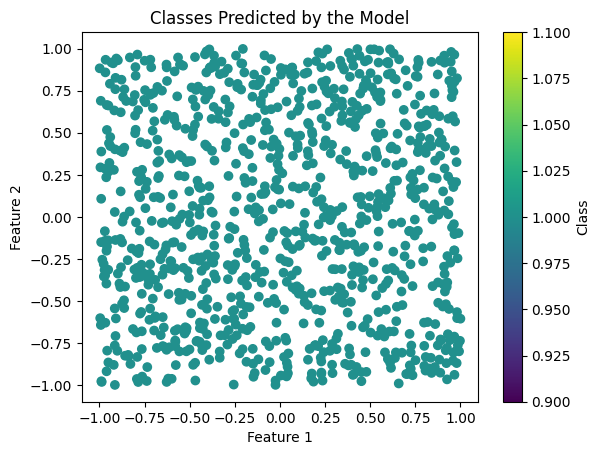

In [177]:
# Função para plotar classes
def plot_classes(model, x):
    y_pred = model.predict(x)
    plt.scatter(x[:, 0], x[:, 1], c=np.argmax(y_pred, axis=1))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Classes Predicted by the Model')
    plt.colorbar(label='Class')
    plt.show()

# Plotar classes
plot_classes(model, x_train)


## Cima - Rascunhos

## Camadas Densas

Época 1, loss: 1.129106879234314, accuracy: 0.3149999976158142
Época 2, loss: 1.1286404132843018, accuracy: 0.31700000166893005
Época 3, loss: 1.1281824111938477, accuracy: 0.3179999887943268
Época 4, loss: 1.1277326345443726, accuracy: 0.3149999976158142
Época 5, loss: 1.1272916793823242, accuracy: 0.3140000104904175
Época 6, loss: 1.1268589496612549, accuracy: 0.3149999976158142
Época 7, loss: 1.126434564590454, accuracy: 0.3149999976158142
Época 8, loss: 1.1260186433792114, accuracy: 0.3149999976158142
Época 9, loss: 1.125610589981079, accuracy: 0.3149999976158142
Época 10, loss: 1.1252102851867676, accuracy: 0.3140000104904175
Época 11, loss: 1.1248177289962769, accuracy: 0.31299999356269836
Época 12, loss: 1.1244324445724487, accuracy: 0.3160000145435333
Época 13, loss: 1.1240545511245728, accuracy: 0.31700000166893005
Época 14, loss: 1.123684048652649, accuracy: 0.3190000057220459
Época 15, loss: 1.1233203411102295, accuracy: 0.3230000138282776
Época 16, loss: 1.1229636669158936,

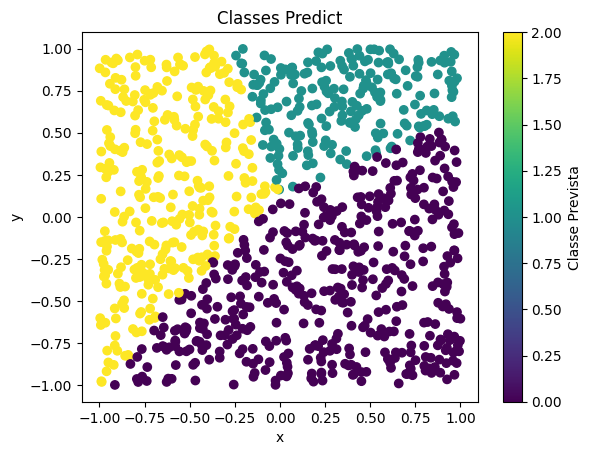

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#classificação de entrada de tamanho 2 e três classes de saída

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2, activation='elu', bias_initializer='zeros')
        self.dense2 = tf.keras.layers.Dense(4, activation='elu', bias_initializer='zeros')
        self.dense3 = tf.keras.layers.Dense(3, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

np.random.seed(0) #aleatoriedade
N = 1000
X_train = np.random.uniform(-1, 1, size=(2, N)) #gera matriz de numero aleatorios entre -1 e 1


#x1 = X_train(1,)

y_train = np.random.randint(0, 3, size=(N,)) #distribui os elementos por 3 classes
# nao quero inteiros, nao quero random



# num_classes = len(np.unique(y_train))
# print("Número de classes:", num_classes)

#class_counts = np.bincount(y_train)
#print("Número de elementos em cada classe:", class_counts)


model = MyModel()#modelo

#parameters
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


@tf.function
def train_step(features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

#checkpoints
checkpoint_path = "./checkpointsSubclassing/"
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)


EPOCHS = 30

for epoch in range(EPOCHS):
    # Reset das métricas no início de cada época
    train_loss.reset_states()
    train_accuracy.reset_states()

    train_step(X_train, y_train)

    template = 'Época {}, loss: {}, accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result()))
    
    checkpoint.save(file_prefix = checkpoint_path) #guarda os checkpoints no igual à rede neural-auido-fp

predictions = model.predict(X_train)
predicted_classes = np.argmax(predictions, axis=1)

plt.scatter(X_train[:, 0], X_train[:, 1], c=predicted_classes, cmap='viridis')
plt.title('Classes Predict')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Classe Prevista')
plt.show()


In [69]:
point = np.array([[0.75, -0.725]])

predictions = model.predict(point)

# classe com maior probabilidade
predicted_class = np.argmax(predictions)

# probabilidade atribuída à classe prevista
confidence = predictions[0][predicted_class]

print(f'class {predicted_class},confidence {confidence:.2f}')

1/1 [==============================] - 0s 14ms/step


class 1,confidence 0.39


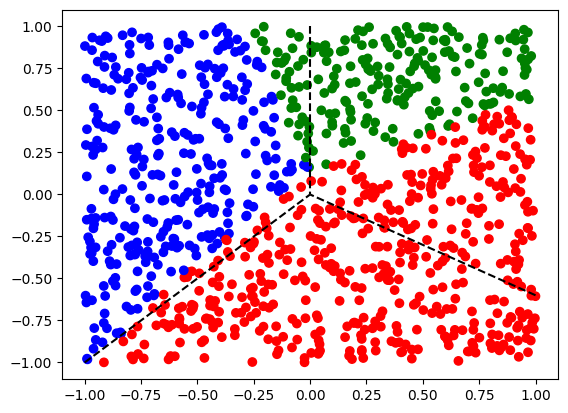

In [55]:
colors = ['red', 'green', 'blue']
class_to_color = dict(zip(range(3), colors))  # Map class index to color


# Adicionando linhas obliquas
plt.plot([1, 0], [-0.6, 0], color='black', linestyle='--')
plt.plot([-1, 0], [-1, 0], color='black', linestyle='--')
plt.plot([0, 0], [1, 0], color='black', linestyle='--')

# Use class_to_color to assign colors based on predicted classes
plt.scatter(X_train[:, 0], X_train[:, 1], c=[class_to_color[cls] for cls in predicted_classes])

### Restore

In [56]:
checkpointpath = "./checkpointsSubclassing/"
latest_checkpoint = tf.train.latest_checkpoint(checkpointpath)
#print(checkpoint)

if latest_checkpoint is None:
    print("Sem checkpoints.")
else:
    print(latest_checkpoint)

./checkpointsSubclassing/-30


In [57]:
modelo = MyModel()

In [58]:
checkpoint = tf.train.Checkpoint(model=modelo)
checkpoint.restore(latest_checkpoint)

### Dá para ver em modo treino, ver os pesos durante o "treino"

In [59]:
for layer in model.layers:
    print(f"Weights of {layer.name}:")
    print(layer.weights)

Weights of dense_130:
[<tf.Variable 'my_model_42/dense_130/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.1741367, -0.5967311],
       [-0.5111724,  1.157518 ]], dtype=float32)>, <tf.Variable 'my_model_42/dense_130/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.01360409, -0.02776285], dtype=float32)>]
Weights of dense_131:
[<tf.Variable 'my_model_42/dense_131/kernel:0' shape=(2, 4) dtype=float32, numpy=
array([[-0.7133687 ,  0.45363405, -0.24368575,  0.7028504 ],
       [-0.19880001,  0.5742553 ,  0.44557905,  0.02065156]],
      dtype=float32)>, <tf.Variable 'my_model_42/dense_131/bias:0' shape=(4,) dtype=float32, numpy=array([-0.03174656, -0.02625547, -0.02665241,  0.02872516], dtype=float32)>]
Weights of dense_132:
[<tf.Variable 'my_model_42/dense_132/kernel:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.09319451,  0.29209855, -0.7900579 ],
       [-0.08154253,  0.10247208,  0.8739167 ],
       [-0.70034045,  0.4523481 , -0.47068447],
       [-0.18232441,  0.16106395, 

### Não dá para ver em modo treino, isto é pesos carregados no pós-treino

In [65]:
for layer in modelo.layers:
    print(f"Weights of {layer.name}:")
    print(layer.weights)

print("\n\n")
#modelo.summary()

Weights of dense_133:
[]
Weights of dense_134:
[]
Weights of dense_135:
[]





## Camadas Convolucionais

Época 1, loss: 1.7999083995819092, accuracy: 0.1469999998807907
Época 2, loss: 1.7998250722885132, accuracy: 0.1459999978542328
Época 3, loss: 1.7997426986694336, accuracy: 0.1459999978542328
Época 4, loss: 1.799661636352539, accuracy: 0.1469999998807907
Época 5, loss: 1.7995816469192505, accuracy: 0.1469999998807907
Época 6, loss: 1.7995030879974365, accuracy: 0.14900000393390656
Época 7, loss: 1.799425482749939, accuracy: 0.14900000393390656
Época 8, loss: 1.799349308013916, accuracy: 0.14800000190734863
Época 9, loss: 1.799274206161499, accuracy: 0.14800000190734863
Época 10, loss: 1.799200177192688, accuracy: 0.1469999998807907
Época 11, loss: 1.7991275787353516, accuracy: 0.1469999998807907
Época 12, loss: 1.7990559339523315, accuracy: 0.1469999998807907
Época 13, loss: 1.7989851236343384, accuracy: 0.14800000190734863
Época 14, loss: 1.7989155054092407, accuracy: 0.14800000190734863
Época 15, loss: 1.79884672164917, accuracy: 0.14900000393390656
Época 16, loss: 1.7987786531448364

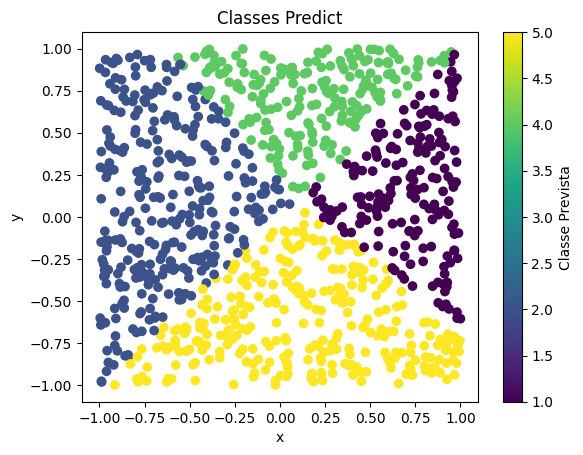

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(3, (1, 2), activation='softmax', padding='same')
        self.flatten = tf.keras.layers.Flatten()
    def call(self, inputs):
        x = self.conv1(inputs)
        return self.flatten(x)

np.random.seed(0)
X_train = np.random.uniform(-1, 1, size=(1000, 2))
X_train = X_train.reshape(-1, 2, 1, 1) 
y_train = np.random.randint(0, 3, size=(1000,))

modelconv = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function
def train_step(features, labels):
    with tf.GradientTape() as tape:
        predictions = modelconv(features)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, modelconv.trainable_variables)
    optimizer.apply_gradients(zip(gradients, modelconv.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

checkpoint_path = "./checkpointsSubclassingConvolucionais/"
checkpoint = tf.train.Checkpoint(model=modelconv, optimizer=optimizer)

EPOCHS = 30

for epoch in range(EPOCHS):
    # Reset das métricas no início de cada época
    train_loss.reset_states()
    train_accuracy.reset_states()

    train_step(X_train, y_train)

    template = 'Época {}, loss: {}, accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result()))
    
    checkpoint.save(file_prefix=checkpoint_path)

predictions = modelconv.predict(X_train)
predicted_classes = np.argmax(predictions, axis=1)

plt.scatter(X_train[:, 0], X_train[:, 1], c=predicted_classes, cmap='viridis')
plt.title('Classes Predict')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Classe Prevista')
plt.show()

# **Functional API**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import os

2024-05-08 09:43:52.302323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
"""
# Gerando a base de dados com 1000 pontos com distribuição uniforme aleatória entre -1 e 1
x_train = np.random.uniform(low=-1, high=1, size=(1000, 2))
y_train = np.random.uniform(low=-1, high=1, size=(1000, 3))

# Definindo as camadas de entrada, camadas ocultas e camada de saída
inputs = Input(shape=(2,))
hidden1 = Dense(4, activation='relu', use_bias=True)(inputs)
outputs = Dense(3, activation='linear', use_bias=True)(hidden1)

# Functional API
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Criando a pasta para os checkpoints se ela não existir
os.makedirs("checkpoints_Functional", exist_ok=True)

# Definindo o callback para salvar os checkpoints na pasta checkpoints_Functional
checkpoint_callback = ModelCheckpoint(filepath='checkpoints_Functional/checkpoint_epoch_{epoch:02d}.h5')

# Treinando o modelo durante 10 épocas
model.fit(x_train, y_train, epochs=10, batch_size=32, callbacks=[checkpoint_callback])
"""

In [2]:
# dados
x_train = np.random.uniform(low=-1, high=1, size=(1000, 2))
y_train = np.random.uniform(low=-1, high=1, size=(1000, 3))

# camadas
inputs = Input(shape=(2,))
hidden1 = Dense(4, activation='sigmoid', use_bias=True)(inputs)
outputs = Dense(3, activation='softmax', use_bias=True)(hidden1)
print(f"input:{inputs}\nhidden1:{hidden1}\noutputs:{outputs}")

# Criando o modelo usando a Functional API
modelFunctional = Model(inputs=inputs, outputs=outputs)

# Compilando o modelo
optimizer = tf.keras.optimizers.Adam()
modelFunctional.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Treinando o modelo durante 10 épocas
modelFunctional.fit(x_train, y_train, epochs=10, batch_size=32)

# Definindo o caminho do diretório de checkpoints
checkpoint_path = "./checkpointsFunctional/"

# Criando o objeto de checkpoint
checkpoint = tf.train.Checkpoint(model=modelFunctional, optimizer=optimizer)

# Salvando os pesos do modelo e do otimizador no diretório de checkpoints
checkpoint.save(file_prefix=checkpoint_path)


input:KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
hidden1:KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
outputs:KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")
Epoch 1/10
32/32 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.3370
Epoch 2/10
32/32 [==============================] - 0s 909us/step - loss: 0.4543 - accuracy: 0.3320
Epoch 3/10
32/32 [==============================] - 0s 916us/step - loss: 0.4541 - accuracy: 0.3320
Epoch 4/10
32/32 [==============================] - 0s 961us/step - loss: 0.4539 - accuracy: 0.3320
Epoch 5/10
32/32 [==============================] - 0s 931us/step - loss: 0.4539 - accuracy: 0.3410
Epoch 6/10
32/32 [===========================

'./checkpointsFunctional/-1'

## Com a variável ativa

In [3]:
modelFunctional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 27 (108.00 Byte)
Trainable params: 27 (108.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# Visualizando os pesos do modelo
print("Pesos do modelo:")
for layer in modelFunctional.layers:
    print(layer.get_weights())

Pesos do modelo:
[]
[array([[ 0.12833789,  0.8102413 ,  0.8219555 ,  0.01545629],
       [-0.32167813,  0.34776473, -0.33565423,  0.3105154 ]],
      dtype=float32), array([ 0.04305182, -0.03943944, -0.00414995,  0.00356846], dtype=float32)]
[array([[-0.05540818, -0.07225739,  0.84846276],
       [ 0.85032964, -0.45342907, -0.5561209 ],
       [-0.6022356 ,  0.75471973, -0.4794936 ],
       [-0.22716342, -0.34613213, -0.18086486]], dtype=float32), array([-0.03411096, -0.00632873,  0.04275241], dtype=float32)]


## Pós-treino

In [5]:
inputs = Input(shape=(2,))
hidden1 = Dense(4, activation='sigmoid', use_bias=True)(inputs)
outputs = Dense(3, activation='softmax', use_bias=True)(hidden1)
modelFunctionalAfter = Model(inputs=inputs, outputs=outputs)

In [6]:
# Carregar os pesos do modelo dos checkpoints
checkpoint_path = tf.train.latest_checkpoint("checkpointsFunctional")
checkpoint = tf.train.Checkpoint(model=modelFunctionalAfter)
checkpoint.restore(checkpoint_path)

# Visualizar a arquitetura do modelo
modelFunctionalAfter.summary()

# Visualizar os pesos de cada camada
for layer in modelFunctionalAfter.layers:
    print(layer.get_weights())

# Ou se quiser apenas os pesos finais
final_weights = modelFunctionalAfter.get_weights()
print(final_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 15        
                                                                 
Total params: 27 (108.00 Byte)
Trainable params: 27 (108.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
[]
[array([[ 0.12833789,  0.8102413 ,  0.8219555 ,  0.01545629],
       [-0.32167813,  0.34776473, -0.33565423,  0.3105154 ]],
      dtype=float32), array([ 0.04305182, -0.03943944, -0.00414995,  0.00356846], dtype=float32)]
[array([[-0.05540818, -0.07225739,  0.84846276],
       [ 0.85